In [1]:
import pandas as pd
import random
import numpy as np
import scipy
import scipy.optimize as sco
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
SPreturns = pd.read_csv("SPreturnsexpanded.csv").dropna(axis = 0)
SPquants = np.array(np.array(SPreturns)[:,1:], dtype = "float")
treasurybond = pd.read_csv("HistoricalPrices.csv")
treasuryreturn = np.array(treasurybond)[2528, 4] - np.array(treasurybond)[0, 4]
inflationrate = 1.3
riskfreerate = treasuryreturn - inflationrate
mean_returns = np.mean(SPquants, axis=1)
covariance_returns = np.cov(SPquants)
print(SPreturns)

   Portfolio A  10/1/2011  10/31/2011  11/30/2011  12/30/2011  1/29/2012  \
0         ALGN  -0.243501    0.615007    0.063830   -0.031429   0.069532   
1          CRL  -0.151120    0.151623   -0.121747   -0.035979   0.223564   
2         INTU  -0.056402    0.170812   -0.008012   -0.012209   0.075490   
4          TDY  -0.139309    0.181818    0.040573   -0.032287   0.010757   
5          WRB  -0.060502    0.215183   -0.020250    0.008355   0.004361   
6          PEG  -0.034925    0.042376   -0.022552    0.002125  -0.084823   
7          CMA  -0.092805    0.151420   -0.012916    0.022998   0.078682   
9         POOL  -0.022727    0.171612    0.043806   -0.013115   0.126578   
10        BF.B  -0.048780    0.110925    0.067737    0.008929   0.002329   
11          CB  -0.072348    0.220606   -0.036313    0.008485  -0.016258   
12          HD  -0.040692    0.133270    0.095531    0.071902   0.064938   
13         HII  -0.205015    0.257460    0.076271   -0.014803   0.185102   
15          

In [3]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def generate_random_weights(number, integer):
    randlist = np.array([np.exp(np.random.randint(0, integer)) for _ in range(number)]) 
    return randlist/np.sum(randlist)
        

print(portfolio_annualised_performance(generate_random_weights(np.shape(SPquants)[0], 10), np.mean(SPquants, axis=1), np.cov(SPquants)))
print(generate_random_weights(np.shape(SPquants)[0], 10))

(0.043079570660002627, 0.014873228438962162)
[2.49068363e-02 6.17378746e-05 1.24003836e-03 4.56184619e-04
 9.16271301e-03 6.77038004e-02 9.16271301e-03 6.17378746e-05
 2.27120948e-05 1.24003836e-03 3.37077374e-03 4.56184619e-04
 2.27120948e-05 2.27120948e-05 4.56184619e-04 1.67820943e-04
 1.67820943e-04 1.24003836e-03 2.27120948e-05 6.77038004e-02
 3.37077374e-03 1.84038010e-01 9.16271301e-03 1.67820943e-04
 1.84038010e-01 1.67820943e-04 1.67820943e-04 4.56184619e-04
 2.49068363e-02 6.17378746e-05 2.27120948e-05 1.24003836e-03
 1.84038010e-01 6.17378746e-05 4.56184619e-04 1.24003836e-03
 9.16271301e-03 1.67820943e-04 1.84038010e-01 2.27120948e-05
 4.56184619e-04 2.49068363e-02]


In [4]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

print(portfolio_volatility(generate_random_weights(np.shape(SPquants)[0], 10), np.mean(SPquants, axis=1), np.cov(SPquants)))

0.054247745099308985


In [5]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

efficient = efficient_return(np.mean(SPquants, axis=1), np.cov(SPquants), 0.01)

print(np.dot(efficient.x, np.mean(SPquants, axis=1)))
print(np.sqrt(np.matmul(np.matmul(efficient.x.T, np.cov(SPquants)), efficient.x)))

print(efficient.x)

0.00999999999997133
0.028109508012583686
[0.00000000e+00 0.00000000e+00 4.11060158e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.24519221e-03
 1.37611387e-02 6.91434462e-18 0.00000000e+00 2.63208678e-18
 4.93000615e-03 1.27057711e-01 0.00000000e+00 9.25219809e-19
 1.81075079e-01 2.96842858e-18 6.09167559e-02 3.68432337e-02
 2.47437170e-18 4.99793722e-02 6.44559965e-18 0.00000000e+00
 1.08041332e-01 1.12095768e-18 1.22641736e-18 6.35368558e-03
 1.06608267e-18 1.30460766e-18 9.56110064e-18 7.12592860e-18
 4.64721280e-02 1.05791706e-17 0.00000000e+00 1.74590533e-01
 3.47864258e-18 2.01628274e-02 2.28366088e-02 9.77774600e-03
 1.33956651e-01 0.00000000e+00]


In [15]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

efficients = efficient_frontier(np.mean(SPquants, axis=1), np.cov(SPquants), np.linspace(0.005, 0.03, 50))

In [17]:
efficient_sharpe_ratios = []

for eff in efficients:
    returns = np.dot(mean_returns, eff.x)
    risks = np.sqrt(np.matmul(np.matmul(eff.x, covariance_returns),eff.x.T))
    sharperatio = (returns-riskfreerate/100)/risks
    efficient_sharpe_ratios.append(sharperatio)


index_max_sharpe = efficient_sharpe_ratios.index(max(efficient_sharpe_ratios))

In [18]:
random_weights = []
for _ in range(1000):
    for n in range(2, 50):
        random_weights.append(generate_random_weights(np.shape(SPquants)[0], n))
                                           

random_weights = np.array(random_weights)
mean_returns = np.mean(SPquants, axis = 1)
covariance_returns = np.cov(SPquants) 

expected_returns = [np.dot(mean_returns, random_weights[i]) for i in range(np.shape(random_weights)[0])]
rand_risks = [np.sqrt(np.matmul(np.matmul(random_weights[i], covariance_returns),random_weights[i].T)) for i in range(np.shape(random_weights)[0])] 
sharpe_ratio = [(expected_returns[i]-riskfreerate/100)/rand_risks[i] for i in range(np.shape(random_weights)[0])]



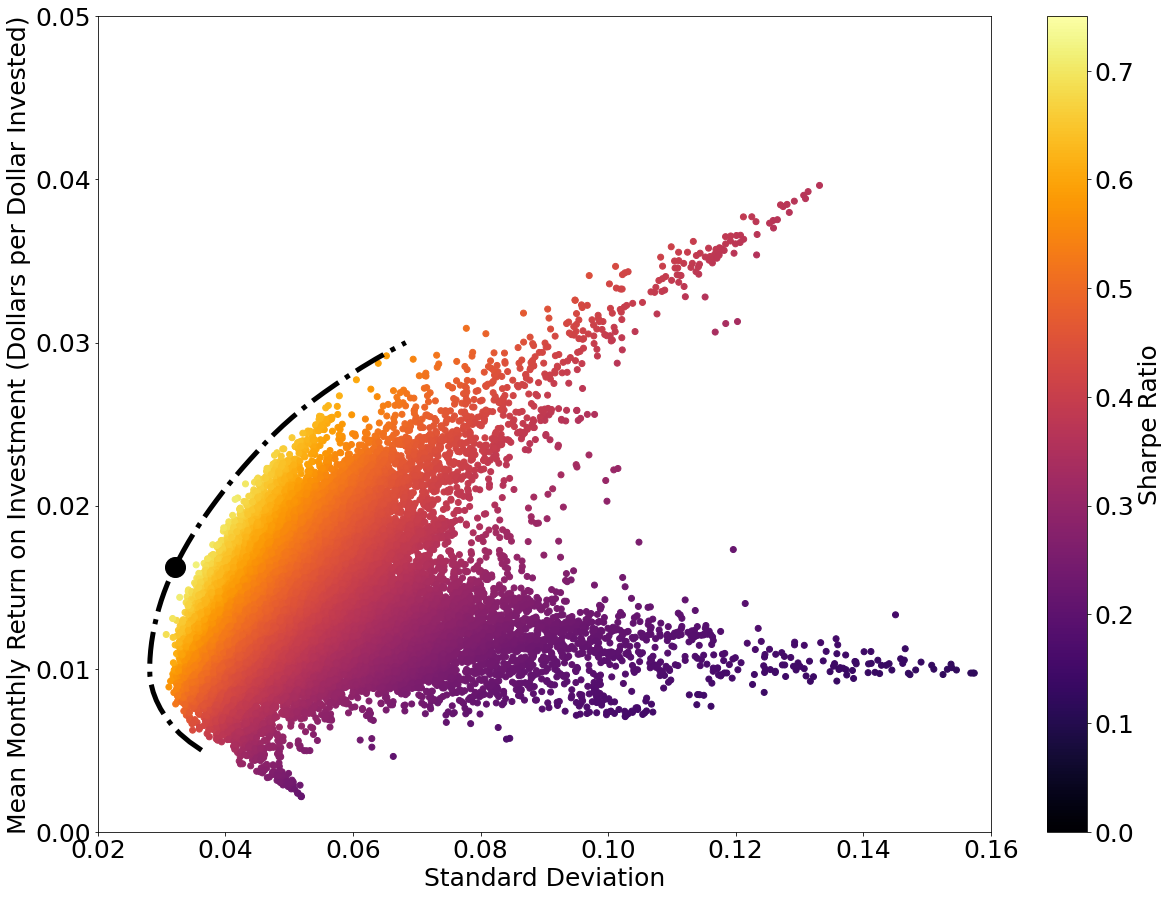

In [19]:
plt.figure(figsize = (20, 15))
plt.scatter(rand_risks, expected_returns, c = sharpe_ratio, cmap = 'inferno', marker= 'o')
plt.plot([p['fun'] for p in efficients], np.linspace(0.005, 0.03, 50), linestyle = '-.', linewidth = 5, color='black', label='efficient frontier')
plt.plot(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T)), np.dot(mean_returns, efficients[index_max_sharpe].x),
        marker = 'o', color = 'black', markersize = 20)
plt.xlim(0.02, .16)
plt.ylim(0,.05)
plt.clim(0,0.75)
plt.xlabel("Standard Deviation")
plt.ylabel("Mean Monthly Return on Investment (Dollars per Dollar Invested)")
plt.colorbar(label = "Sharpe Ratio")
plt.rc('font', size = 25)
plt.savefig("SandPwsharpe.png", dpi = 600)
plt.show()

In [20]:
np.savetxt("optimal_SPweights.csv", efficients[index_max_sharpe].x, delimiter=",")

In [21]:
print(efficients[index_max_sharpe].x)

[0.00000000e+00 2.89374044e-02 3.87884528e-02 5.73036188e-03
 0.00000000e+00 1.03812805e-17 0.00000000e+00 2.14022780e-01
 0.00000000e+00 0.00000000e+00 1.34263458e-02 2.83305207e-03
 2.07959358e-18 0.00000000e+00 8.99630080e-02 0.00000000e+00
 2.32074407e-01 1.96241753e-18 0.00000000e+00 9.79729708e-03
 0.00000000e+00 0.00000000e+00 9.32659870e-19 2.64140543e-18
 1.30700171e-01 0.00000000e+00 0.00000000e+00 5.74053429e-19
 0.00000000e+00 3.83460517e-18 0.00000000e+00 0.00000000e+00
 1.24402630e-02 0.00000000e+00 0.00000000e+00 5.23895124e-02
 0.00000000e+00 4.80990176e-04 1.79273879e-18 1.94487913e-02
 1.48967163e-01 0.00000000e+00]


In [22]:
print(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T))*np.sqrt(12))
print(np.dot(mean_returns, efficients[index_max_sharpe].x)*12)
print(max(efficient_sharpe_ratios))

0.11105830643716286
0.19469387755104448
0.7852360940841348
